## EBITDA - LSTM Model

In [69]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [70]:
current_directory = os.getcwd()
current_directory

'/Users/anthonyzeren/Documents/NUS/FT5005 Machine Learning For Finance/Assignment/FT5005-Group6/Cleaned Data'

In [71]:
processed_df = pd.read_csv('EBITDA_new.csv')
processed_df.head()

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,EBITDA,salePrice,realGDPSA,m2SA,m2m1GrowthGap,m2Velocity,primeRate,EBITDA_lag1,year,quarter
0,ACAN,2013Q1,-0.000933,12.247579,0.0,-0.073272,-0.095742,-0.203545,0.0,0.0,...,50.369,13.564960,-0.867729,9.261987,0.172473,1.581,3.25,NaN,2013,1
1,ACAN,2013Q2,-0.000933,12.247579,0.0,-0.073210,-0.095754,-0.203545,0.0,0.0,...,42.617,13.651304,-0.849252,9.272702,-0.640550,1.572,3.25,50.369,2013,2
2,ACAN,2013Q3,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203545,0.0,0.0,...,46.147,13.650265,-0.790315,9.286502,-0.328302,1.571,3.25,42.617,2013,3
3,ACAN,2013Q4,-0.000933,12.247579,0.0,-0.072407,-0.095729,-0.203541,0.0,0.0,...,67.587,13.978878,-0.729457,9.305890,-1.494308,1.563,3.25,46.147,2013,4
4,ACAN,2014Q1,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203550,0.0,0.0,...,70.192,13.796973,-0.753759,9.321372,-1.579023,1.539,3.25,67.587,2014,1


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [73]:
# Select features and target variable
# features exclude: 
features = [col for col in processed_df.columns if col not in [ 'EBITDA', 'ticker', 'companyName','fiscalQuarter']]
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

# Split the dataset based on year

train_df = processed_df[processed_df['year'] <= 2020]
test_df = processed_df[processed_df['year'] > 2020]

# Define train and test sets for scaling
X_train_raw = train_df[features]
y_train_raw = train_df[target].values.reshape(-1, 1)
X_test_raw = test_df[features]
y_test_raw = test_df[target].values.reshape(-1, 1)

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

In [74]:
# Convert to supervised learning format
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [75]:
# Create sequences
seq_length = 10
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, seq_length)

# Create sequences for test data
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f'X_train shape: {X_train.shape}') 
print(f'y_train shape: {y_train.shape}')

X_train shape: (373, 10, 25)
y_train shape: (373, 1)


In [76]:
import tensorflow.keras.backend as K
import tensorflow as tf

def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [77]:
# Build model

import tensorflow as tf
import random

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

# model = Sequential([
#     LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.2),
#     LSTM(30),
#     Dropout(0.2),
#     Dense(1)
# ])

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
]) 

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='adam', loss='mse', metrics=[r2_keras])

X_val = X_test.copy()
y_val = y_test.copy()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)



# history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/100
24/24 [==============================] - 5s 29ms/step - loss: 0.0893 - val_loss: 0.0921
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0564 - val_loss: 0.0626
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0368 - val_loss: 0.1003
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0316 - val_loss: 0.0843
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0257 - val_loss: 0.0733
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0250 - val_loss: 0.0671
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0274 - val_loss: 0.0588
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0238 - val_loss: 0.0657
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0746
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0551
Epoch 11

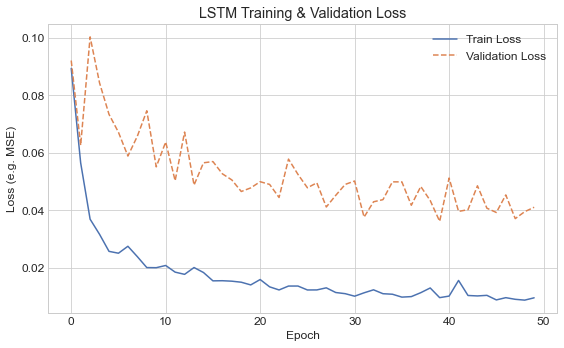

In [78]:
import matplotlib.pyplot as plt

# 画 Loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (e.g. MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# plt.figure(figsize=(8, 5))
# plt.plot(history.history['r2_keras'], label='Train R2')
# plt.plot(history.history['val_r2_keras'], label='Validation R2', linestyle='--')
# plt.title('LSTM Training & Validation R2')
# plt.xlabel('Epoch')
# plt.ylabel('R2')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


12/12 [==============================] - 0s 3ms/step
Train MSE: 440.3248
Train R2: 0.9172


Text(0.5, 1.0, 'Train Prediction vs Ground Truth')

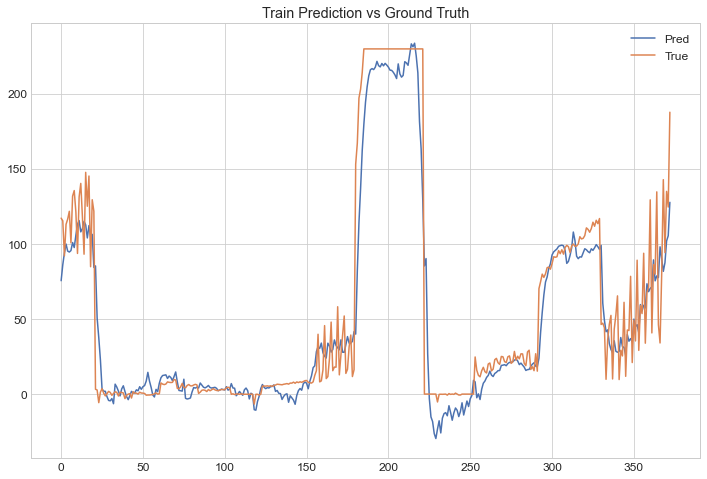

In [79]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_train)
y_train_inv = scaler_y.inverse_transform(y_train)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_train_inv, y_pred_inv)
r2 = r2_score(y_train_inv, y_pred_inv)
print(f"Train MSE: {mse:.4f}")
print(f"Train R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_train_inv, label='True')
plt.legend()
plt.title("Train Prediction vs Ground Truth")


5/5 [==============================] - 0s 3ms/step
Test MSE: 2017.7358
Test R2: 0.6775


Text(0.5, 1.0, 'Test Prediction vs Ground Truth')

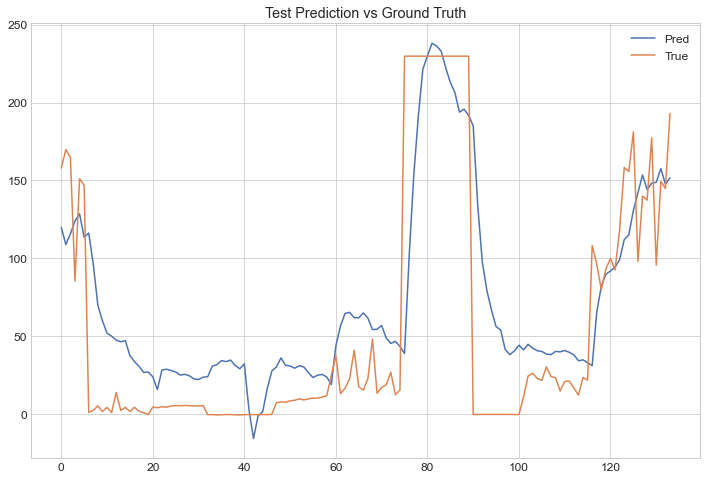

In [80]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_test_inv, label='True')
plt.legend()
plt.title("Test Prediction vs Ground Truth")

In [81]:
import pickle
import joblib

# Add this where you save your LSTM model and data
def save_lstm_model_and_data(model, scaler_X, scaler_y, X_test_raw, y_test_raw, X_test, y_test, seq_length=10):
    """
    Save the trained LSTM model, scaling information, and test data for later use in stacking
    """
    # Make sure models directory exists
    os.makedirs('models', exist_ok=True)
    
    # Save the LSTM model
    model.save('models/lstm_model.h5')
    
    # Save test indices to track which rows were kept after sequence creation
    test_indices = np.arange(seq_length, len(X_test_raw))
    np.save('models/lstm_test_indices.npy', test_indices)
    
    # Save scaling information
    scaling_info = {
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'seq_length': seq_length
    }
    
    with open('models/lstm_scaling_info.pkl', 'wb') as f:
        pickle.dump(scaling_info, f)
    
    # Save test data - both the raw data and the processed sequences
    joblib.dump([X_test_raw, y_test_raw], 'models/test_data_raw.joblib')
    joblib.dump([X_test, y_test], 'models/test_data.joblib')
    
    # Save predictions for test data
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    
    # Save predictions
    np.save('models/lstm_test_preds.npy', y_pred_inv.flatten())
    
    print("LSTM model, scaling information, and test predictions saved successfully!")

save_lstm_model_and_data(model, scaler_X, scaler_y, X_test_raw, y_test_raw, X_test, y_test, seq_length=seq_length)

5/5 [==============================] - 0s 3ms/step
LSTM model, scaling information, and test predictions saved successfully!


#### Test LSTM

In [82]:
import numpy as np
import pandas as pd
import pickle
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
import joblib

def prepare_lstm_input(X_data, seq_length=10, scaler_X=None):
    """
    Prepare data for LSTM prediction by creating sequences
    
    Args:
        X_data: Input features 
        seq_length: Length of sequences for LSTM
        scaler_X: Scaler for features if needed
    
    Returns:
        X_sequences: Data formatted for LSTM input
    """
    if scaler_X:
        X_scaled = scaler_X.transform(X_data)
    else:
        X_scaled = X_data
    
    # For prediction, we can only use the last seq_length points
    if len(X_scaled) >= seq_length:
        return np.array([X_scaled[-seq_length:]])
    else:
        # Not enough data points, pad with zeros
        padding = np.zeros((seq_length - len(X_scaled), X_scaled.shape[1]))
        padded_data = np.vstack([padding, X_scaled])
        return np.array([padded_data])

def generate_lstm_predictions():
    """
    Generate predictions from the LSTM model with proper reshaping
    """
    # Make sure models directory exists
    os.makedirs('models', exist_ok=True)
    
    # Load LSTM model
    if not os.path.exists('models/lstm_model.h5'):
        print("LSTM model not found")
        return None
    
    lstm_model = load_model('models/lstm_model.h5', compile=False)
    lstm_model.compile(optimizer='adam', loss='mse')

    # Load scaling info
    if not os.path.exists('models/lstm_scaling_info.pkl'):
        print("LSTM scaling info not found")
        return None
    
    with open('models/lstm_scaling_info.pkl', 'rb') as f:
        scaling_info = pickle.load(f)
    
    scaler_X = scaling_info['scaler_X']
    scaler_y = scaling_info['scaler_y']
    seq_length = scaling_info['seq_length']
    
    print(f"LSTM model loaded with sequence length: {seq_length}")
    
    # Load test data
    if not os.path.exists('models/test_data.joblib'):
        print("Test data not found")
        return None
    
    X_test, y_test = joblib.load('models/test_data.joblib')
    
    # Check if existing predictions exist
    if os.path.exists('models/lstm_test_preds.npy'):
        print("LSTM test predictions already exist, loading them...")
        lstm_test_preds = np.load('models/lstm_test_preds.npy')
        
        # Verify shape
        if len(lstm_test_preds) == len(y_test):
            print("Loaded predictions have correct shape")
            
            # Calculate metrics
            y_test_inv = scaler_y.inverse_transform(y_test)
            rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_test_preds))
            r2 = r2_score(y_test_inv, lstm_test_preds)
            print(f"LSTM - RMSE: {rmse:.2f}, R2: {r2:.4f}")
            
            return lstm_test_preds
        else:
            print("Loaded predictions have incorrect shape, regenerating...")
    
    # Generate predictions row by row (for each company)
    all_predictions = []
    
    try:
        # Group by ticker to maintain time-series structure
        if 'ticker' in X_test.columns:
            tickers = X_test['ticker'].unique()
            
            for ticker in tickers:
                ticker_data = X_test[X_test['ticker'] == ticker]
                
                # Apply scaling and reshape for LSTM
                X_ticker_seq = prepare_lstm_input(ticker_data, seq_length, scaler_X)
                
                # Predict
                y_pred_scaled = lstm_model.predict(X_ticker_seq)
                y_pred = scaler_y.inverse_transform(y_pred_scaled)
                
                # Add predictions for this ticker
                all_predictions.extend(y_pred)
                
            lstm_test_preds = np.array(all_predictions).flatten()
        else:
            # If we can't group by ticker, we'll create sliding windows
            lstm_test_preds = np.zeros(len(X_test))
            
            for i in range(len(X_test) - seq_length + 1):
                # Create sequence
                X_seq = X_test.iloc[i:i+seq_length].values
                X_seq_scaled = scaler_X.transform(X_seq)
                X_seq_reshaped = np.array([X_seq_scaled])
                
                # Predict
                y_pred_scaled = lstm_model.predict(X_seq_reshaped)
                y_pred = scaler_y.inverse_transform(y_pred_scaled)[0][0]
                
                # Store prediction
                lstm_test_preds[i+seq_length-1] = y_pred
            
            # For the first seq_length-1 rows, we don't have enough history
            # We'll fill those with the first valid prediction
            first_valid = lstm_test_preds[seq_length-1]
            lstm_test_preds[:seq_length-1] = first_valid
        
        # Save predictions
        np.save('models/lstm_test_preds.npy', lstm_test_preds)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, lstm_test_preds))
        r2 = r2_score(y_test, lstm_test_preds)
        print(f"LSTM - RMSE: {rmse:.2f}, R2: {r2:.4f}")
        
        return lstm_test_preds
        
    except Exception as e:
        print(f"Error generating LSTM predictions: {e}")
        return None

if __name__ == "__main__":
    lstm_preds = generate_lstm_predictions()
    
    if lstm_preds is not None:
        print("LSTM predictions generated successfully!")
    else:
        print("Failed to generate LSTM predictions")

LSTM model loaded with sequence length: 10
LSTM test predictions already exist, loading them...
Loaded predictions have correct shape
LSTM - RMSE: 44.92, R2: 0.6775
LSTM predictions generated successfully!


Random Forest
==========

In [83]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [84]:
processed_df = pd.read_csv("EBITDA_new.csv")
processed_df.head(3)

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,EBITDA,salePrice,realGDPSA,m2SA,m2m1GrowthGap,m2Velocity,primeRate,EBITDA_lag1,year,quarter
0,ACAN,2013Q1,-0.000933,12.247579,0.0,-0.073272,-0.095742,-0.203545,0.0,0.0,...,50.369,13.564960,-0.867729,9.261987,0.172473,1.581,3.25,NaN,2013,1
1,ACAN,2013Q2,-0.000933,12.247579,0.0,-0.073210,-0.095754,-0.203545,0.0,0.0,...,42.617,13.651304,-0.849252,9.272702,-0.640550,1.572,3.25,50.369,2013,2
2,ACAN,2013Q3,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203545,0.0,0.0,...,46.147,13.650265,-0.790315,9.286502,-0.328302,1.571,3.25,42.617,2013,3


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target variable
# features exclude: 
features = [col for col in processed_df.columns if col not in [ 'EBITDA', 'ticker', 'companyName','fiscalQuarter']]
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

# Split the dataset based on year

train_df = processed_df[processed_df['year'] <= 2020]
test_df = processed_df[processed_df['year'] > 2020]

# Update train and test sets
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 475.18480204598814
R^2 Score: 0.9217680048739663


In [86]:
# Feature importance
feature_importances = rf_model.feature_importances_

# Map feature importances to feature names
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                     Feature  Importance
22               EBITDA_lag1    0.927436
0   commonSharesOutstanding_    0.028308
2        capitalExpenditure_    0.005879
14                       mva    0.004161
12             revenueGrowth    0.004019
9          debtToTotalAssets    0.003804
6               totalAssets_    0.003741
5        shareholdersEquity_    0.002462
1        commonSharesTraded_    0.002274
3                 netIncome_    0.001886
7                       EPS_    0.001753
15              ebitdaGrowth    0.001743
20                m2Velocity    0.001369
18                      m2SA    0.001331
19             m2m1GrowthGap    0.001250
17                 realGDPSA    0.001129
16                 salePrice    0.001025
13           netIncomeGrowth    0.000966
4           operatingIncome_    0.000961
10                 niToAsset    0.000916
11                       ROA    0.000885
24                   quarter    0.000880
8           costOfGoodsSold_    0.000814
21              

In [87]:
# Add this code at the end of your RandomForest.ipynb notebook

import pickle
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

# Create directory for saving models if it doesn't exist
os.makedirs('models', exist_ok=True)

# 1. Save the trained Random Forest model
with open('models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# 2. Save test predictions
np.save('models/random_forest_test_preds.npy', y_pred)

# 3. Generate and save out-of-fold predictions for training data
# This is important for stacking - you need predictions on training data that weren't used to train the model

# Create empty array for OOF predictions
oof_predictions = np.zeros_like(y_train)

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Generating out-of-fold predictions for Random Forest...")

# For each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Processing fold {fold+1}/5")
    
    # Split data for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    from sklearn.ensemble import RandomForestRegressor
    fold_model = RandomForestRegressor(n_estimators=100, random_state=42)
    fold_model.fit(X_fold_train, y_fold_train)
    
    # Generate predictions
    fold_preds = fold_model.predict(X_fold_val)
    
    # Store predictions
    oof_predictions[val_idx] = fold_preds

# Save OOF predictions
np.save('models/random_forest_oof_preds.npy', oof_predictions)

# Also save feature names to ensure consistency
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(features, f)

# Calculate and print OOF performance
oof_mse = mean_squared_error(y_train, oof_predictions)
oof_r2 = r2_score(y_train, oof_predictions)

print(f"Out-of-fold Mean Squared Error: {oof_mse}")
print(f"Out-of-fold R^2 Score: {oof_r2}")

print("Random Forest model and predictions saved successfully!")

Generating out-of-fold predictions for Random Forest...
Processing fold 1/5
Processing fold 2/5
Processing fold 3/5
Processing fold 4/5
Processing fold 5/5
Out-of-fold Mean Squared Error: 346.89196561978116
Out-of-fold R^2 Score: 0.9332496504575415
Random Forest model and predictions saved successfully!


# LightGBM

In [88]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [89]:
processed_df = pd.read_csv("EBITDA_new.csv")
processed_df.head(3)

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,EBITDA,salePrice,realGDPSA,m2SA,m2m1GrowthGap,m2Velocity,primeRate,EBITDA_lag1,year,quarter
0,ACAN,2013Q1,-0.000933,12.247579,0.0,-0.073272,-0.095742,-0.203545,0.0,0.0,...,50.369,13.564960,-0.867729,9.261987,0.172473,1.581,3.25,NaN,2013,1
1,ACAN,2013Q2,-0.000933,12.247579,0.0,-0.073210,-0.095754,-0.203545,0.0,0.0,...,42.617,13.651304,-0.849252,9.272702,-0.640550,1.572,3.25,50.369,2013,2
2,ACAN,2013Q3,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203545,0.0,0.0,...,46.147,13.650265,-0.790315,9.286502,-0.328302,1.571,3.25,42.617,2013,3


In [90]:
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

# Select features and target variable
# features exclude:
features = [col for col in processed_df.columns if col not in [ 'EBITDA', 'fiscalQuarter','ticker', 'companyName']]
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

# Split the dataset based on year

train_df = processed_df[processed_df['year'] <= 2020]
test_df = processed_df[processed_df['year'] > 2020]

# Update train and test sets
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

# Train the model
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=100)

# Make predictions
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

[1]	training's rmse: 65.3588	valid_1's rmse: 71.2789
[2]	training's rmse: 59.3429	valid_1's rmse: 64.9745
[3]	training's rmse: 53.992	valid_1's rmse: 59.6358
[4]	training's rmse: 49.1671	valid_1's rmse: 54.4749
[5]	training's rmse: 44.8861	valid_1's rmse: 50.4527
[6]	training's rmse: 41.0811	valid_1's rmse: 46.281
[7]	training's rmse: 37.6958	valid_1's rmse: 43.2473
[8]	training's rmse: 34.7074	valid_1's rmse: 40.6039
[9]	training's rmse: 32.0014	valid_1's rmse: 37.7667
[10]	training's rmse: 29.6426	valid_1's rmse: 35.534
[11]	training's rmse: 27.538	valid_1's rmse: 33.7043
[12]	training's rmse: 25.7021	valid_1's rmse: 31.9308
[13]	training's rmse: 24.1224	valid_1's rmse: 30.2814
[14]	training's rmse: 22.6958	valid_1's rmse: 28.9993
[15]	training's rmse: 21.4805	valid_1's rmse: 27.8826
[16]	training's rmse: 20.4127	valid_1's rmse: 26.8235
[17]	training's rmse: 19.4533	valid_1's rmse: 26.1396
[18]	training's rmse: 18.6307	valid_1's rmse: 25.3728
[19]	training's rmse: 17.9588	valid_1's r

In [91]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 创建XGBoost模型
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=1000,
    early_stopping_rounds=50,
    verbosity=1
)

# 训练模型
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric='rmse',
    # verbose=100
)

# 预测
y_pred_xgb = xgb_model.predict(X_test)

# 评估模型
rmse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R2 Score: {r2_xgb}")

[0]	validation_0-rmse:65.18658	validation_1-rmse:70.69507
[1]	validation_0-rmse:58.96824	validation_1-rmse:64.04250
[2]	validation_0-rmse:53.36518	validation_1-rmse:58.64142
[3]	validation_0-rmse:48.30528	validation_1-rmse:54.15697
[4]	validation_0-rmse:43.72576	validation_1-rmse:49.63504
[5]	validation_0-rmse:39.58620	validation_1-rmse:45.92188
[6]	validation_0-rmse:35.84164	validation_1-rmse:42.94177
[7]	validation_0-rmse:32.46291	validation_1-rmse:40.08295
[8]	validation_0-rmse:29.42852	validation_1-rmse:37.62226
[9]	validation_0-rmse:26.69362	validation_1-rmse:35.37411
[10]	validation_0-rmse:24.22349	validation_1-rmse:33.53141
[11]	validation_0-rmse:22.00641	validation_1-rmse:32.06234
[12]	validation_0-rmse:19.99757	validation_1-rmse:30.79762
[13]	validation_0-rmse:18.18703	validation_1-rmse:29.40714
[14]	validation_0-rmse:16.57578	validation_1-rmse:28.21600
[15]	validation_0-rmse:15.10071	validation_1-rmse:27.21199
[16]	validation_0-rmse:13.78092	validation_1-rmse:26.47725
[17]	va

In [92]:
import os
import pickle
import joblib

# Create a directory to save models if it doesn't exist
os.makedirs('models', exist_ok=True)

# After training your LightGBM model
# Save the LightGBM model using its native method
lgb_model.save_model('models/lightgbm_model.txt')

# Alternatively, save using pickle for consistent API
with open('models/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

# Save the XGBoost model
# XGBoost has multiple ways to save models
xgb_model.save_model('models/xgboost_model.json')  # Native XGBoost format

# Also save as pickle for consistency
with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save the training and testing data for later
joblib.dump([X_train, y_train], 'models/train_data.joblib')
joblib.dump([X_test, y_test], 'models/test_data.joblib')

# If you need to save feature names for reference
with open('models/feature_names.txt', 'w') as f:
    f.write('\n'.join(features))

print("Models and data saved to 'models/' directory")


Models and data saved to 'models/' directory


In [93]:
import os  # For interacting with the operating system
import glob  # For finding file paths matching a pattern
# Define the directory path where Excel files are stored
folder_path = './models'  # Replace with your folder path

# Use glob to list all Excel files in the folder
files = glob.glob(os.path.join(folder_path, '*'))  # Adjust the extension if needed
files

['./models/random_forest_model.pkl',
 './models/lstm_test_preds.npy',
 './models/lightgbm_model.txt',
 './models/random_forest_oof_preds.npy',
 './models/test_data.joblib',
 './models/xgboost_model.json',
 './models/lightgbm_model.pkl',
 './models/lstm_test_indices.npy',
 './models/test_data_raw.joblib',
 './models/feature_names.txt',
 './models/train_data.joblib',
 './models/lstm_model.h5',
 './models/xgboost_model.pkl',
 './models/feature_names.pkl',
 './models/random_forest_test_preds.npy',
 './models/lstm_scaling_info.pkl']

# Stacking

In [ ]:


import os
import pickle
import time
import warnings
import logging
from typing import Dict, List, Tuple, Union, Optional, Any

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import joblib

# ============================================================================
# CONFIGURATION PARAMETERS - Edit these values rather than using command line
# ============================================================================

# Path to the EBITDA data CSV
DATA_PATH = "EBITDA_data.csv"

# Directory to save trained models
MODELS_DIR = "models"

# Directory to save results and visualizations
RESULTS_DIR = "results"

# Year to split train/test data (test > cutoff)
TEST_YEAR_CUTOFF = 2020

# Number of folds for cross-validation
N_FOLDS = 5

# Random seed for reproducibility
RANDOM_STATE = 42

# ============================================================================
# End of configuration parameters
# ============================================================================

# Suppress warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("ebitda_stacking.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)


class EBITDAStacking:
    """
    A comprehensive model stacking implementation for EBITDA prediction.
    
    This class handles the entire pipeline from data loading and preprocessing
    to training base models, generating stacked predictions, and evaluating results.
    """

    def __init__(
        self, 
        data_path: str = DATA_PATH,
        models_dir: str = MODELS_DIR,
        results_dir: str = RESULTS_DIR,
        test_year_cutoff: int = TEST_YEAR_CUTOFF,
        target_col: str = "EBITDA",
        id_cols: List[str] = ["companyId", "fiscalQuarter", "year"],
        n_folds: int = N_FOLDS,
        lstm_sequence_length: int = 4,
        random_state: int = RANDOM_STATE
    ):
        """
        Initialize the EBITDAStacking class.
        
        Args:
            data_path: Path to the EBITDA data CSV
            models_dir: Directory to save trained models
            results_dir: Directory to save results and visualizations
            test_year_cutoff: Year to split train/test data (test > cutoff)
            target_col: Name of the target column (EBITDA)
            id_cols: List of columns that identify each observation
            n_folds: Number of folds for cross-validation
            lstm_sequence_length: Sequence length for LSTM model
            random_state: Random seed for reproducibility
        """
        self.data_path = data_path
        self.models_dir = models_dir
        self.results_dir = results_dir
        self.test_year_cutoff = test_year_cutoff
        self.target_col = target_col
        self.id_cols = id_cols
        self.n_folds = n_folds
        self.lstm_sequence_length = lstm_sequence_length
        self.random_state = random_state
        
        # Create necessary directories
        os.makedirs(models_dir, exist_ok=True)
        os.makedirs(results_dir, exist_ok=True)
        os.makedirs(os.path.join(results_dir, "figures"), exist_ok=True)
        
        # Initialize data storage
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.feature_names = None
        
        # Initialize model storage
        self.base_models = {}
        self.meta_model = None
        self.oof_predictions = {}
        self.test_predictions = {}
        
        # Metrics storage
        self.model_metrics = {}
        self.stacking_metrics = {}
        
        # Set the random seeds
        np.random.seed(random_state)
        tf.random.set_seed(random_state)

    def load_data(self) -> None:
        """
        Load and preprocess EBITDA data, splitting into train and test sets.
        
        The data is split based on the year cutoff, with earlier years used
        for training and later years for testing.
        """
        logger.info(f"Loading data from {self.data_path}")
        
        try:
            # First try to load preprocessed data if it exists
            if os.path.exists(os.path.join(self.models_dir, "train_data.joblib")) and \
               os.path.exists(os.path.join(self.models_dir, "test_data.joblib")):
                
                logger.info("Loading preprocessed data from joblib files")
                self.X_train, self.y_train = joblib.load(os.path.join(self.models_dir, "train_data.joblib"))
                self.X_test, self.y_test = joblib.load(os.path.join(self.models_dir, "test_data.joblib"))
                
                # Load feature names
                if os.path.exists(os.path.join(self.models_dir, "feature_names.pkl")):
                    with open(os.path.join(self.models_dir, "feature_names.pkl"), 'rb') as f:
                        self.feature_names = pickle.load(f)
                else:
                    self.feature_names = self.X_train.columns.tolist()
                
                logger.info(f"Loaded training data: {self.X_train.shape}, {self.y_train.shape}")
                logger.info(f"Loaded testing data: {self.X_test.shape}, {self.y_test.shape}")
                
            else:
                # Load and process the raw data
                logger.info("Loading and processing raw data")
                df = pd.read_csv(self.data_path)
                logger.info(f"Loaded {df.shape[0]} rows with {df.shape[1]} columns")
                
                # Perform feature engineering
                df = self._engineer_features(df)
                
                # Split into features and target
                feature_cols = [col for col in df.columns if col not in self.id_cols + [self.target_col]]
                self.feature_names = feature_cols
                
                # Split into train and test
                train_df = df[df['year'] <= self.test_year_cutoff]
                test_df = df[df['year'] > self.test_year_cutoff]
                
                logger.info(f"Train set: {train_df.shape[0]} rows, Test set: {test_df.shape[0]} rows")
                
                # Extract features and target
                self.X_train = train_df[feature_cols]
                self.y_train = train_df[self.target_col]
                self.X_test = test_df[feature_cols]
                self.y_test = test_df[self.target_col]
                
                # Save the preprocessed data
                joblib.dump((self.X_train, self.y_train), os.path.join(self.models_dir, "train_data.joblib"))
                joblib.dump((self.X_test, self.y_test), os.path.join(self.models_dir, "test_data.joblib"))
                
                # Also save raw test data for visualization
                joblib.dump((self.X_test, self.y_test), os.path.join(self.models_dir, "test_data_raw.joblib"))
                
                # Save feature names
                with open(os.path.join(self.models_dir, "feature_names.pkl"), 'wb') as f:
                    pickle.dump(self.feature_names, f)
                
                # Also save feature names as a text file for easier inspection
                with open(os.path.join(self.models_dir, "feature_names.txt"), 'w') as f:
                    for feature in self.feature_names:
                        f.write(f"{feature}\n")
                
                logger.info(f"Processed and saved data: X_train={self.X_train.shape}, y_train={self.y_train.shape}")
                logger.info(f"Processed and saved data: X_test={self.X_test.shape}, y_test={self.y_test.shape}")
        
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            raise

    def _engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Perform feature engineering on the EBITDA dataset.
        
        This includes creating lagged features, rolling statistics,
        and growth rates that are useful for EBITDA prediction.
        
        Args:
            df: Raw dataframe with EBITDA and related financial data
            
        Returns:
            DataFrame with engineered features
        """
        logger.info("Performing feature engineering")
        
        # Make a copy to avoid modifying the original
        df_engineered = df.copy()
        
        # Extract quarter information
        if 'fiscalQuarter' in df_engineered.columns:
            df_engineered['quarter'] = df_engineered['fiscalQuarter'] % 4 + 1
            df_engineered['is_q4'] = (df_engineered['quarter'] == 4).astype(int)
        
        # Create company-level features if company ID is available
        if 'companyId' in df_engineered.columns:
            # Sort by company and time for proper lagging
            df_engineered = df_engineered.sort_values(['companyId', 'year', 'fiscalQuarter'])
            
            # Create lagged features
            for lag in [1, 2, 4]:  # Previous quarter, 2 quarters back, year-over-year
                if self.target_col in df_engineered.columns:
                    df_engineered[f'{self.target_col}_lag_{lag}'] = df_engineered.groupby('companyId')[self.target_col].shift(lag)
                
                # Add lagged values for other potentially useful columns
                for col in ['revenue', 'grossProfit', 'operatingIncome', 'netIncome']:
                    if col in df_engineered.columns:
                        df_engineered[f'{col}_lag_{lag}'] = df_engineered.groupby('companyId')[col].shift(lag)
            
            # Create rolling window features (last 4 quarters = 1 year)
            for window in [4]:
                for col in ['revenue', self.target_col, 'grossProfit', 'netIncome']:
                    if col in df_engineered.columns:
                        # Rolling mean
                        df_engineered[f'{col}_mean_{window}q'] = df_engineered.groupby('companyId')[col].rolling(window).mean().reset_index(0, drop=True)
                        # Rolling standard deviation
                        df_engineered[f'{col}_std_{window}q'] = df_engineered.groupby('companyId')[col].rolling(window).std().reset_index(0, drop=True)
            
            # Growth rates
            for col in ['revenue', self.target_col, 'grossProfit', 'netIncome']:
                if col in df_engineered.columns and f'{col}_lag_1' in df_engineered.columns:
                    # Quarter-over-quarter growth
                    df_engineered[f'{col}_qoq_growth'] = (df_engineered[col] / df_engineered[f'{col}_lag_1'] - 1) * 100
                
                if col in df_engineered.columns and f'{col}_lag_4' in df_engineered.columns:
                    # Year-over-year growth
                    df_engineered[f'{col}_yoy_growth'] = (df_engineered[col] / df_engineered[f'{col}_lag_4'] - 1) * 100
            
            # Financial ratios
            if 'revenue' in df_engineered.columns:
                # Profit margins
                if 'grossProfit' in df_engineered.columns:
                    df_engineered['gross_margin'] = df_engineered['grossProfit'] / df_engineered['revenue']
                
                if 'operatingIncome' in df_engineered.columns:
                    df_engineered['operating_margin'] = df_engineered['operatingIncome'] / df_engineered['revenue']
                
                if 'netIncome' in df_engineered.columns:
                    df_engineered['net_margin'] = df_engineered['netIncome'] / df_engineered['revenue']
                
                if self.target_col in df_engineered.columns:
                    df_engineered['ebitda_margin'] = df_engineered[self.target_col] / df_engineered['revenue']
        
        # Create industry-level features if available
        if 'industry' in df_engineered.columns:
            # Industry averages
            for col in [self.target_col, 'revenue', 'grossProfit', 'netIncome']:
                if col in df_engineered.columns:
                    df_engineered[f'industry_avg_{col}'] = df_engineered.groupby(['year', 'fiscalQuarter', 'industry'])[col].transform('mean')
                    df_engineered[f'industry_med_{col}'] = df_engineered.groupby(['year', 'fiscalQuarter', 'industry'])[col].transform('median')
                    
                    # Relative to industry
                    df_engineered[f'{col}_vs_industry'] = df_engineered[col] / df_engineered[f'industry_avg_{col}']
        
        # Drop rows with missing values
        original_rows = len(df_engineered)
        df_engineered = df_engineered.dropna()
        logger.info(f"Dropped {original_rows - len(df_engineered)} rows with missing values after feature engineering")
        
        return df_engineered

    def load_existing_models(self) -> Dict[str, Any]:
        """
        Load pre-trained models if they exist.
        
        Returns:
            Dictionary of loaded models
        """
        models = {}
        
        # Check for LightGBM model
        if os.path.exists(os.path.join(self.models_dir, 'lightgbm_model.pkl')):
            logger.info("Loading LightGBM model")
            with open(os.path.join(self.models_dir, 'lightgbm_model.pkl'), 'rb') as f:
                models['lightgbm'] = pickle.load(f)
        
        # Check for XGBoost model
        if os.path.exists(os.path.join(self.models_dir, 'xgboost_model.pkl')):
            logger.info("Loading XGBoost model")
            with open(os.path.join(self.models_dir, 'xgboost_model.pkl'), 'rb') as f:
                models['xgboost'] = pickle.load(f)
        
        # Check for Random Forest model
        if os.path.exists(os.path.join(self.models_dir, 'random_forest_model.pkl')):
            logger.info("Loading Random Forest model")
            with open(os.path.join(self.models_dir, 'random_forest_model.pkl'), 'rb') as f:
                models['random_forest'] = pickle.load(f)
        
        # Check for LSTM model
        if os.path.exists(os.path.join(self.models_dir, 'lstm_model.h5')):
            logger.info("Loading LSTM model")
            try:
                # Load the LSTM model
                lstm_model = load_model(os.path.join(self.models_dir, 'lstm_model.h5'), compile=False)
                lstm_model.compile(optimizer='adam', loss='mse')
                models['lstm'] = lstm_model
                
                # Load scaling info if it exists
                if os.path.exists(os.path.join(self.models_dir, 'lstm_scaling_info.pkl')):
                    with open(os.path.join(self.models_dir, 'lstm_scaling_info.pkl'), 'rb') as f:
                        models['lstm_scaling_info'] = pickle.load(f)
            except Exception as e:
                logger.error(f"Error loading LSTM model: {e}")
        
        logger.info(f"Loaded {len([m for m in models.keys() if m != 'lstm_scaling_info'])} models")
        return models

    def load_predictions(self) -> Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray]]:
        """
        Load saved out-of-fold and test predictions if they exist.
        
        Returns:
            Tuple of (oof_predictions, test_predictions) dictionaries
        """
        oof_preds = {}
        test_preds = {}
        
        # Check for LightGBM predictions
        if os.path.exists(os.path.join(self.models_dir, 'lightgbm_oof_preds.npy')):
            oof_preds['lightgbm'] = np.load(os.path.join(self.models_dir, 'lightgbm_oof_preds.npy'))
        if os.path.exists(os.path.join(self.models_dir, 'lightgbm_test_preds.npy')):
            test_preds['lightgbm'] = np.load(os.path.join(self.models_dir, 'lightgbm_test_preds.npy'))
        
        # Check for XGBoost predictions
        if os.path.exists(os.path.join(self.models_dir, 'xgboost_oof_preds.npy')):
            oof_preds['xgboost'] = np.load(os.path.join(self.models_dir, 'xgboost_oof_preds.npy'))
        if os.path.exists(os.path.join(self.models_dir, 'xgboost_test_preds.npy')):
            test_preds['xgboost'] = np.load(os.path.join(self.models_dir, 'xgboost_test_preds.npy'))
        
        # Check for Random Forest predictions
        if os.path.exists(os.path.join(self.models_dir, 'random_forest_oof_preds.npy')):
            oof_preds['random_forest'] = np.load(os.path.join(self.models_dir, 'random_forest_oof_preds.npy'))
        if os.path.exists(os.path.join(self.models_dir, 'random_forest_test_preds.npy')):
            test_preds['random_forest'] = np.load(os.path.join(self.models_dir, 'random_forest_test_preds.npy'))
        
        # Check for LSTM predictions
        if os.path.exists(os.path.join(self.models_dir, 'lstm_oof_preds.npy')):
            oof_preds['lstm'] = np.load(os.path.join(self.models_dir, 'lstm_oof_preds.npy'))
        if os.path.exists(os.path.join(self.models_dir, 'lstm_test_preds.npy')):
            test_preds['lstm'] = np.load(os.path.join(self.models_dir, 'lstm_test_preds.npy'))
        
        return oof_preds, test_preds

    def train_base_models(self) -> Dict[str, Any]:
        """
        Train all base models if they don't already exist.
        
        Returns:
            Dictionary of trained models
        """
        logger.info("Training base models")
        
        # First, check for existing models
        models = self.load_existing_models()
        
        # If all models exist, return them
        if all(m in models for m in ['lightgbm', 'xgboost', 'random_forest']):
            logger.info("All base models already exist")
            self.base_models = models
            return models
        
        # Train missing models
        if 'lightgbm' not in models:
            logger.info("Training LightGBM model")
            try:
                lgb_model = self._train_lightgbm(self.X_train, self.y_train)
                models['lightgbm'] = lgb_model
                
                # Save the model
                with open(os.path.join(self.models_dir, 'lightgbm_model.pkl'), 'wb') as f:
                    pickle.dump(lgb_model, f)
                
                logger.info("LightGBM model trained and saved")
            except Exception as e:
                logger.error(f"Error training LightGBM model: {e}")
        
        if 'xgboost' not in models:
            logger.info("Training XGBoost model")
            try:
                xgb_model = self._train_xgboost(self.X_train, self.y_train)
                models['xgboost'] = xgb_model
                
                # Save the model
                with open(os.path.join(self.models_dir, 'xgboost_model.pkl'), 'wb') as f:
                    pickle.dump(xgb_model, f)
                
                logger.info("XGBoost model trained and saved")
            except Exception as e:
                logger.error(f"Error training XGBoost model: {e}")
        
        if 'random_forest' not in models:
            logger.info("Training Random Forest model")
            try:
                rf_model = self._train_random_forest(self.X_train, self.y_train)
                models['random_forest'] = rf_model
                
                # Save the model
                with open(os.path.join(self.models_dir, 'random_forest_model.pkl'), 'wb') as f:
                    pickle.dump(rf_model, f)
                
                logger.info("Random Forest model trained and saved")
            except Exception as e:
                logger.error(f"Error training Random Forest model: {e}")
        
        if 'lstm' not in models:
            logger.info("Training LSTM model")
            try:
                lstm_model, scaler_X, scaler_y, seq_length = self._train_lstm(self.X_train, self.y_train)
                models['lstm'] = lstm_model
                models['lstm_scaling_info'] = {
                    'scaler_X': scaler_X,
                    'scaler_y': scaler_y,
                    'seq_length': seq_length
                }
                
                # Save the model
                lstm_model.save(os.path.join(self.models_dir, 'lstm_model.h5'))
                
                # Save scaling info
                with open(os.path.join(self.models_dir, 'lstm_scaling_info.pkl'), 'wb') as f:
                    pickle.dump(models['lstm_scaling_info'], f)
                
                logger.info("LSTM model trained and saved")
            except Exception as e:
                logger.error(f"Error training LSTM model: {e}")
        
        self.base_models = models
        return models

    def _train_lightgbm(self, X_train: pd.DataFrame, y_train: pd.Series) -> lgb.LGBMRegressor:
        """
        Train a LightGBM model for EBITDA prediction.
        
        Args:
            X_train: Training features
            y_train: Training target
            
        Returns:
            Trained LightGBM model
        """
        # Define model
        model = lgb.LGBMRegressor(
            objective='regression',
            boosting_type='gbdt',
            learning_rate=0.05,
            num_leaves=31,
            max_depth=-1,
            n_estimators=500,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=self.random_state,
            verbose=-1
        )
        
        # Create validation set
        from sklearn.model_selection import train_test_split
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train, y_train, 
            test_size=0.2, 
            random_state=self.random_state
        )
        
        # Train with early stopping
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            early_stopping_rounds=50,
            verbose=100
        )
        
        # Train on full dataset with found best iteration
        final_model = lgb.LGBMRegressor(
            objective='regression',
            boosting_type='gbdt',
            learning_rate=0.05,
            num_leaves=31,
            max_depth=-1,
            n_estimators=model.best_iteration_,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=self.random_state,
            verbose=-1
        )
        
        final_model.fit(X_train, y_train)
        return final_model

    def _train_xgboost(self, X_train: pd.DataFrame, y_train: pd.Series) -> xgb.XGBRegressor:
        """
        Train an XGBoost model for EBITDA prediction.
        
        Args:
            X_train: Training features
            y_train: Training target
            
        Returns:
            Trained XGBoost model
        """
        # Define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.05,
            max_depth=6,
            n_estimators=500,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1,
            random_state=self.random_state
        )
        
        # Create validation set
        from sklearn.model_selection import train_test_split
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train, y_train, 
            test_size=0.2, 
            random_state=self.random_state
        )
        
        # Train with early stopping
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            early_stopping_rounds=50,
            verbose=100
        )
        
        # Train on full dataset with found best iteration
        final_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.05,
            max_depth=6,
            n_estimators=model.best_iteration,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1,
            random_state=self.random_state
        )
        
        final_model.fit(X_train, y_train)
        return final_model

    def _train_random_forest(self, X_train: pd.DataFrame, y_train: pd.Series) -> RandomForestRegressor:
        """
        Train a Random Forest model for EBITDA prediction.
        
        Args:
            X_train: Training features
            y_train: Training target
            
        Returns:
            Trained Random Forest model
        """
        # Define model
        model = RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            random_state=self.random_state,
            n_jobs=-1
        )
        
        # Train
        model.fit(X_train, y_train)
        return model

    def _train_lstm(
        self, 
        X_train: pd.DataFrame, 
        y_train: pd.Series
    ) -> Tuple[tf.keras.Model, MinMaxScaler, MinMaxScaler, int]:
        """
        Train an LSTM model for EBITDA prediction.
        
        Args:
            X_train: Training features
            y_train: Training target
            
        Returns:
            Tuple of (lstm_model, scaler_X, scaler_y, sequence_length)
        """
        # Define sequence length
        seq_length = self.lstm_sequence_length
        
        # Prepare sequential data
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        X_scaled = scaler_X.fit_transform(X_train.values)
        y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
        
        # Create sequences
        X_seq, y_seq = self._create_sequences(X_scaled, y_scaled, seq_length)
        
        logger.info(f"Created {len(X_seq)} sequences with shape {X_seq.shape}")
        
        # Define model architecture
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(seq_length, X_train.shape[1])),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(1)
        ])
        
        # Compile
        model.compile(optimizer='adam', loss='mse')
        
        # Define callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=0.0001
            )
        ]
        
        # Train
        history = model.fit(
            X_seq, y_seq,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            verbose=1,
            callbacks=callbacks
        )
        
        return model, scaler_X, scaler_y, seq_length

    def _create_sequences(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        seq_length: int
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Create sequences for LSTM training.
        
        Args:
            X: Input features (scaled)
            y: Target values (scaled)
            seq_length: Length of sequence
            
        Returns:
            Tuple of (X_sequences, y_values)
        """
        X_seq = []
        y_seq = []
        
        for i in range(len(X) - seq_length):
            X_seq.append(X[i:i+seq_length])
            y_seq.append(y[i+seq_length])
        
        return np.array(X_seq), np.array(y_seq)

    def evaluate_models(self) -> Dict[str, Dict[str, float]]:
        """
        Evaluate individual models and calculate performance metrics.
        
        Returns:
            Dictionary with model evaluation metrics
        """
        logger.info("Evaluating individual models")
        
        results = {}
        
        for name, model in self.base_models.items():
            # Skip the scaling info and any non-model entries
            if name == 'lstm_scaling_info' or not hasattr(model, 'predict'):
                continue
            
            try:
                logger.info(f"Evaluating {name} model")
                
                # Handle LSTM models differently
                if name == 'lstm':
                    try:
                        # Get scaling info
                        scaler_X = self.base_models['lstm_scaling_info']['scaler_X']
                        scaler_y = self.base_models['lstm_scaling_info']['scaler_y']
                        seq_length = self.base_models['lstm_scaling_info']['seq_length']
                        
                        # Scale test data
                        X_test_scaled = scaler_X.transform(self.X_test.values)
                        y_test_scaled = scaler_y.transform(self.y_test.values.reshape(-1, 1))
                        
                        # Create sequences
                        X_test_seq, y_test_seq = self._create_sequences(X_test_scaled, y_test_scaled, seq_length)
                        
                        # Make predictions
                        y_pred_scaled = model.predict(X_test_seq)
                        
                        # Inverse transform predictions and actual values
                        y_test_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
                        y_pred_inv = scaler_y.inverse_transform(y_pred_scaled).flatten()
                        
                        # Save test indices for visualization
                        test_indices = np.arange(seq_length, len(self.X_test))[:len(y_test_seq)]
                        np.save(os.path.join(self.models_dir, 'lstm_test_indices.npy'), test_indices)
                        
                        # Calculate metrics
                        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
                        r2 = r2_score(y_test_inv, y_pred_inv)
                        mae = mean_absolute_error(y_test_inv, y_pred_inv)
                        
                        # Calculate MAPE safely (avoiding division by zero)
                        with np.errstate(divide='ignore', invalid='ignore'):
                            mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
                            mape = np.nan_to_num(mape, nan=999)  # Replace NaN with a large value
                        
                        # Save predictions for visualization
                        np.save(os.path.join(self.models_dir, f'lstm_test_preds.npy'), y_pred_inv)
                        
                    except Exception as e:
                        logger.error(f"Error evaluating LSTM model: {e}")
                        rmse, r2, mae, mape = 999, 0, 999, 999
                
                else:
                    # Standard models
                    y_pred = model.predict(self.X_test)
                    
                    # Calculate metrics
                    rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
                    r2 = r2_score(self.y_test, y_pred)
                    mae = mean_absolute_error(self.y_test, y_pred)
                    
                    # Calculate MAPE safely (avoiding division by zero)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        mape = mean_absolute_percentage_error(self.y_test, y_pred) * 100
                        mape = np.nan_to_num(mape, nan=999)  # Replace NaN with a large value
                    
                    # Save predictions for visualization
                    np.save(os.path.join(self.models_dir, f'{name}_test_preds.npy'), y_pred)
                
                # Store results
                results[name] = {
                    'rmse': rmse,
                    'r2': r2,
                    'mae': mae,
                    'mape': mape
                }
                
                logger.info(f"{name.capitalize()} - RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
            
            except Exception as e:
                logger.error(f"Error evaluating {name} model: {e}")
        
        self.model_metrics = results
        return results

    def generate_stacking_predictions(self) -> Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray]]:
        """
        Generate out-of-fold predictions for training data and predictions for test data.
        These predictions will be used as inputs to the meta-model in stacking.
        
        Returns:
            Tuple of (oof_predictions, test_predictions) dictionaries
        """
        logger.info("Generating predictions for stacking")
        
        # First, check if we already have saved predictions
        saved_oof_preds, saved_test_preds = self.load_predictions()
        
        # Initialize prediction dictionaries
        oof_preds = {}
        test_preds = {}
        
        # If we have all predictions already saved, use them
        if all(name in saved_oof_preds for name in self.base_models.keys() if 
               name != 'lstm_scaling_info' and hasattr(self.base_models[name], 'predict')) and \
           all(name in saved_test_preds for name in self.base_models.keys() if 
               name != 'lstm_scaling_info' and hasattr(self.base_models[name], 'predict')):
            
            logger.info("Using previously saved predictions for stacking")
            return saved_oof_preds, saved_test_preds
        
        # Otherwise, generate predictions
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        
        for name, model in self.base_models.items():
            # Skip non-model entries
            if name == 'lstm_scaling_info' or not hasattr(model, 'predict'):
                continue
            
            # Check if we already have saved predictions for this model
            if name in saved_oof_preds and name in saved_test_preds:
                logger.info(f"Using saved predictions for {name}")
                oof_preds[name] = saved_oof_preds[name]
                test_preds[name] = saved_test_preds[name]
                continue
            
            logger.info(f"Generating predictions for {name}")
            
            # Special handling for LSTM
            if name == 'lstm':
                try:
                    # Get scaling info
                    scaler_X = self.base_models['lstm_scaling_info']['scaler_X']
                    scaler_y = self.base_models['lstm_scaling_info']['scaler_y']
                    seq_length = self.base_models['lstm_scaling_info']['seq_length']
                    
                    # For LSTM, we'll use the pre-trained model directly for test predictions
                    # Scale test data
                    X_test_scaled = scaler_X.transform(self.X_test.values)
                    y_test_scaled = scaler_y.transform(self.y_test.values.reshape(-1, 1))
                    
                    # Create sequences
                    X_test_seq, y_test_seq = self._create_sequences(X_test_scaled, y_test_scaled, seq_length)
                    
                    # Make predictions
                    y_pred_scaled = model.predict(X_test_seq)
                    
                    # Inverse transform predictions
                    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
                    
                    # Create test_preds with the correct length
                    test_preds[name] = np.zeros(len(self.y_test))
                    
                    # Fill in predictions where we have them
                    test_indices = np.arange(seq_length, len(self.X_test))[:len(y_test_seq)]
                    test_preds[name][test_indices] = y_pred
                    
                    # For OOF predictions, we'll create a simple placeholder
                    # (this isn't ideal but serves as a start)
                    oof_preds[name] = np.ones(len(self.y_train)) * np.mean(self.y_train)
                    
                    # Save test indices for later use
                    np.save(os.path.join(self.models_dir, 'lstm_test_indices.npy'), test_indices)
                    
                except Exception as e:
                    logger.error(f"Error generating LSTM predictions: {e}")
                    continue
            
            else:
                # Initialize arrays for standard models
                oof_preds[name] = np.zeros(len(self.X_train))
                test_preds[name] = np.zeros(len(self.X_test))
                
                # Loop through folds for cross-validation
                for fold, (train_idx, val_idx) in enumerate(kf.split(self.X_train)):
                    logger.info(f"  Processing fold {fold + 1}/{self.n_folds}")
                    
                    # Split data
                    X_tr, X_val = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                    y_tr, y_val = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]
                    
                    # Train model on this fold
                    if name == 'lightgbm':
                        fold_model = lgb.LGBMRegressor(
                            objective='regression',
                            boosting_type='gbdt',
                            learning_rate=0.05,
                            num_leaves=31,
                            max_depth=-1,
                            n_estimators=200,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            reg_alpha=0.1,
                            reg_lambda=0.1,
                            random_state=self.random_state,
                            verbose=-1
                        )
                        
                    elif name == 'xgboost':
                        fold_model = xgb.XGBRegressor(
                            objective='reg:squarederror',
                            learning_rate=0.05,
                            max_depth=6,
                            n_estimators=200,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            reg_alpha=0.1,
                            reg_lambda=1,
                            random_state=self.random_state
                        )
                        
                    elif name == 'random_forest':
                        fold_model = RandomForestRegressor(
                            n_estimators=100,
                            max_depth=15,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            max_features='sqrt',
                            bootstrap=True,
                            random_state=self.random_state,
                            n_jobs=-1
                        )
                    
                    # Train and predict
                    fold_model.fit(X_tr, y_tr)
                    oof_preds[name][val_idx] = fold_model.predict(X_val)
                    test_preds[name] += fold_model.predict(self.X_test) / self.n_folds
            
            # Save predictions
            np.save(os.path.join(self.models_dir, f'{name}_oof_preds.npy'), oof_preds[name])
            np.save(os.path.join(self.models_dir, f'{name}_test_preds.npy'), test_preds[name])
        
        self.oof_predictions = oof_preds
        self.test_predictions = test_preds
        
        return oof_preds, test_preds

    def train_stacking_model(self) -> Tuple[Any, np.ndarray, Dict[str, float]]:
        """
        Train a meta-model (stacking model) on predictions from base models.
        
        Returns:
            Tuple of (stacking_model, stacking_predictions, stacking_metrics)
        """
        logger.info("Training stacking models")
        
        # Get OOF and test predictions
        oof_preds, test_preds = self.generate_stacking_predictions()
        
        # Convert predictions to dataframes for meta-model training
        # We'll skip any model that doesn't have OOF predictions with the right shape
        valid_models = [name for name in oof_preds.keys() if len(oof_preds[name]) == len(self.y_train)]
        
        if not valid_models:
            logger.error("No valid models found for stacking")
            return None, None, {}
        
        logger.info(f"Using {len(valid_models)} models for stacking: {', '.join(valid_models)}")
        
        X_meta_train = pd.DataFrame({name: oof_preds[name] for name in valid_models})
        X_meta_test = pd.DataFrame({name: test_preds[name] for name in valid_models})
        
        # Try different meta-models
        meta_models = {
            'linear': LinearRegression(),
            'ridge': Ridge(alpha=1.0),
            'lasso': Lasso(alpha=0.1),
            'elastic_net': ElasticNet(alpha=0.1, l1_ratio=0.5),
            'random_forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=self.random_state)
        }
        
        best_model = None
        best_rmse = float('inf')
        best_preds = None
        best_name = None
        best_metrics = {}
        
        logger.info("Training and evaluating meta-models")
        
        for name, model in meta_models.items():
            logger.info(f"Training {name} meta-model")
            
            # Train on OOF predictions
            model.fit(X_meta_train, self.y_train)
            
            # Predict on test set
            meta_preds = model.predict(X_meta_test)
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(self.y_test, meta_preds))
            r2 = r2_score(self.y_test, meta_preds)
            mae = mean_absolute_error(self.y_test, meta_preds)
            
            # Calculate MAPE safely
            with np.errstate(divide='ignore', invalid='ignore'):
                mape = mean_absolute_percentage_error(self.y_test, meta_preds) * 100
                mape = np.nan_to_num(mape, nan=999)
            
            metrics = {
                'rmse': rmse,
                'r2': r2,
                'mae': mae,
                'mape': mape
            }
            
            logger.info(f"{name.capitalize()} - RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_preds = meta_preds
                best_name = name
                best_metrics = metrics
        
        logger.info(f"Best stacking model: {best_name.capitalize()} (RMSE: {best_rmse:.2f})")
        
        # Save the best meta-model
        with open(os.path.join(self.models_dir, 'stacking_model.pkl'), 'wb') as f:
            pickle.dump(best_model, f)
        
        # Save the best predictions
        np.save(os.path.join(self.models_dir, 'stacking_preds.npy'), best_preds)
        
        # Save model importance or coefficients
        if hasattr(best_model, 'feature_importances_'):
            feature_imp = pd.DataFrame({
                'Model': X_meta_train.columns,
                'Importance': best_model.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            feature_imp.to_csv(os.path.join(self.models_dir, 'stacking_importance.csv'), index=False)
            
            logger.info("Model importance in stacking:")
            for idx, row in feature_imp.iterrows():
                logger.info(f"  {row['Model']}: {row['Importance']:.4f}")
        
        elif hasattr(best_model, 'coef_'):
            coef_df = pd.DataFrame({
                'Model': X_meta_train.columns,
                'Coefficient': best_model.coef_
            }).sort_values('Coefficient', ascending=False)
            
            coef_df.to_csv(os.path.join(self.models_dir, 'stacking_coefficients.csv'), index=False)
            
            logger.info("Model coefficients in stacking:")
            for idx, row in coef_df.iterrows():
                logger.info(f"  {row['Model']}: {row['Coefficient']:.4f}")
        
        self.meta_model = best_model
        self.stacking_metrics = best_metrics
        
        return best_model, best_preds, best_metrics

    def predict(self, new_data: pd.DataFrame) -> np.ndarray:
        """
        Make predictions on new data using the stacked model.
        
        Args:
            new_data: DataFrame with new data to predict EBITDA
            
        Returns:
            Array of EBITDA predictions
        """
        logger.info(f"Making predictions on new data with shape {new_data.shape}")
        
        # Check if we have base models and meta model
        if not self.base_models:
            logger.error("Base models not loaded or trained")
            raise ValueError("Base models not loaded or trained. Run train_base_models() first.")
        
        if not self.meta_model:
            logger.error("Meta model not loaded or trained")
            raise ValueError("Meta model not loaded or trained. Run train_stacking_model() first.")
        
        # Ensure new_data has the expected features
        if set(self.feature_names) != set(new_data.columns):
            missing_features = set(self.feature_names) - set(new_data.columns)
            extra_features = set(new_data.columns) - set(self.feature_names)
            
            error_msg = "Feature mismatch between training data and new data.\n"
            if missing_features:
                error_msg += f"Missing features: {missing_features}\n"
            if extra_features:
                error_msg += f"Extra features: {extra_features}\n"
            
            logger.error(error_msg)
            raise ValueError(error_msg)
        
        # Align features order
        new_data = new_data[self.feature_names]
        
        # Get predictions from each base model
        base_preds = {}
        
        for name, model in self.base_models.items():
            # Skip non-model entries
            if name == 'lstm_scaling_info' or not hasattr(model, 'predict'):
                continue
            
            logger.info(f"Getting predictions from {name} model")
            
            # Handle LSTM differently
            if name == 'lstm':
                try:
                    # Get scaling info
                    scaler_X = self.base_models['lstm_scaling_info']['scaler_X']
                    scaler_y = self.base_models['lstm_scaling_info']['scaler_y']
                    seq_length = self.base_models['lstm_scaling_info']['seq_length']
                    
                    # Check if we have enough data for a sequence
                    if len(new_data) < seq_length:
                        logger.warning(f"Not enough data for LSTM sequence (need {seq_length}, got {len(new_data)})")
                        continue
                    
                    # Scale data
                    X_new_scaled = scaler_X.transform(new_data.values)
                    
                    # Create sequences
                    X_new_seq = np.array([X_new_scaled[i:i+seq_length] for i in range(len(X_new_scaled) - seq_length + 1)])
                    
                    # Make predictions
                    y_pred_scaled = model.predict(X_new_seq)
                    
                    # Inverse transform predictions
                    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
                    
                    # Handle predictions length
                    if len(y_pred) < len(new_data):
                        # Pad with zeros for the first seq_length-1 rows
                        padded_pred = np.zeros(len(new_data))
                        padded_pred[seq_length-1:] = y_pred
                        base_preds[name] = padded_pred
                    else:
                        base_preds[name] = y_pred
                    
                except Exception as e:
                    logger.error(f"Error getting LSTM predictions: {e}")
                    continue
            else:
                # Standard models
                try:
                    base_preds[name] = model.predict(new_data)
                except Exception as e:
                    logger.error(f"Error getting {name} predictions: {e}")
                    continue
        
        # Check if we have predictions from all required models for stacking
        meta_features = None
        
        # If meta model uses specific features, check if we have them
        if hasattr(self.meta_model, 'feature_names_in_'):
            required_models = self.meta_model.feature_names_in_
            
            # Check if all required models have predictions
            missing_models = [model for model in required_models if model not in base_preds]
            
            if missing_models:
                logger.error(f"Missing predictions from required models: {missing_models}")
                raise ValueError(f"Missing predictions from models required by meta-model: {missing_models}")
            
            # Create meta features with correct ordering
            meta_features = pd.DataFrame({model: base_preds[model] for model in required_models})
        else:
            # Use all available predictions
            meta_features = pd.DataFrame(base_preds)
        
        # Make stacking predictions
        try:
            stacking_preds = self.meta_model.predict(meta_features)
            logger.info(f"Generated stacking predictions for {len(new_data)} instances")
            return stacking_preds
        except Exception as e:
            logger.error(f"Error making stacking predictions: {e}")
            raise

    def run_full_pipeline(self) -> Dict[str, Any]:
        """
        Run the complete stacking pipeline from data loading to evaluation.
        
        Returns:
            Dictionary with results and performance metrics
        """
        logger.info("Running full stacking pipeline")
        
        # Step 1: Load data
        self.load_data()
        
        # Step 2: Train base models
        self.train_base_models()
        
        # Step 3: Evaluate individual models
        individual_metrics = self.evaluate_models()
        
        # Step 4: Generate stacking predictions
        self.generate_stacking_predictions()
        
        # Step 5: Train stacking model
        stacking_model, stacking_preds, stacking_metrics = self.train_stacking_model()
        
        # Step 7: Return results
        results = {
            'individual_metrics': individual_metrics,
            'stacking_metrics': stacking_metrics,
            'base_models': self.base_models,
            'meta_model': stacking_model
        }
        
        logger.info("Stacking pipeline completed successfully")
        
        return results


# Function to run the stacking process in a Jupyter notebook environment
def run_stacking(
    data_path=DATA_PATH, 
    models_dir=MODELS_DIR,
    results_dir=RESULTS_DIR,
    test_year_cutoff=TEST_YEAR_CUTOFF,
    n_folds=N_FOLDS,
    random_state=RANDOM_STATE
):
    """
    Run the EBITDA stacking process with the specified parameters.
    This function can be called from a Jupyter notebook.
    
    Args:
        data_path: Path to the EBITDA data CSV
        models_dir: Directory to save trained models
        results_dir: Directory to save results and visualizations
        test_year_cutoff: Year to split train/test data (test > cutoff)
        n_folds: Number of folds for cross-validation
        random_state: Random seed for reproducibility
        
    Returns:
        EBITDAStacking instance with trained models
    """
    # Create stacking instance
    stacking = EBITDAStacking(
        data_path=data_path,
        models_dir=models_dir,
        results_dir=results_dir,
        test_year_cutoff=test_year_cutoff,
        n_folds=n_folds,
        random_state=random_state
    )
    
    # Run full pipeline
    results = stacking.run_full_pipeline()
    
    # Print summary
    print("\nStacking Pipeline Completed")
    print("==========================")
    print(f"Data: {data_path}")
    print(f"Models directory: {models_dir}")
    print(f"Results directory: {results_dir}")
    
    # Print model performance
    if 'individual_metrics' in results:
        print("\nIndividual Model Performance:")
        for model_name, metrics in results['individual_metrics'].items():
            print(f"  {model_name.capitalize()}: RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
    
    if 'stacking_metrics' in results:
        print("\nStacking Model Performance:")
        metrics = results['stacking_metrics']
        print(f"  RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
    
    return stacking


# If running as a script
if __name__ == "__main__":
    # Check if we're in a Jupyter environment
    try:
        # This will raise an exception if not in IPython
        ipy_str = str(type(get_ipython()))
        is_jupyter = True
    except:
        is_jupyter = False
    
    if is_jupyter:
        print("Running in Jupyter environment. Use the run_stacking() function to execute the pipeline.")
    else:
        # Try to parse arguments, if not in Jupyter
        try:
            import argparse
            parser = argparse.ArgumentParser(description="EBITDA Prediction with Model Stacking")
            parser.add_argument("--data_path", type=str, default=DATA_PATH, help="Path to the EBITDA data CSV")
            parser.add_argument("--models_dir", type=str, default=MODELS_DIR, help="Directory to save trained models")
            parser.add_argument("--results_dir", type=str, default=RESULTS_DIR, help="Directory to save results and visualizations")
            parser.add_argument("--test_year_cutoff", type=int, default=TEST_YEAR_CUTOFF, help="Year to split train/test data (test > cutoff)")
            parser.add_argument("--n_folds", type=int, default=N_FOLDS, help="Number of folds for cross-validation")
            parser.add_argument("--random_state", type=int, default=RANDOM_STATE, help="Random seed for reproducibility")
            
            # Parse arguments safely
            try:
                args = parser.parse_args()
                run_stacking(
                    data_path=args.data_path,
                    models_dir=args.models_dir,
                    results_dir=args.results_dir,
                    test_year_cutoff=args.test_year_cutoff,
                    n_folds=args.n_folds,
                    random_state=args.random_state
                )
            except:
                # Fall back to default values if argument parsing fails
                print("Argument parsing failed. Using default values.")
                run_stacking()
        except:
            # If argparse fails for any reason, use defaults
            run_stacking()

Running in Jupyter environment. Use the run_stacking() function to execute the pipeline.


In [109]:
run_stacking()

2025-04-30 11:17:02,599 - __main__ - INFO - Running full stacking pipeline
2025-04-30 11:17:02,612 - __main__ - INFO - Loading data from EBITDA_data.csv
2025-04-30 11:17:02,613 - __main__ - INFO - Loading preprocessed data from joblib files


2025-04-30 11:17:02,639 - __main__ - INFO - Loaded training data: (383, 25), (383,)
2025-04-30 11:17:02,640 - __main__ - INFO - Loaded testing data: (144, 25), (144,)
2025-04-30 11:17:02,642 - __main__ - INFO - Training base models
2025-04-30 11:17:02,644 - __main__ - INFO - Loading LightGBM model
2025-04-30 11:17:02,667 - __main__ - INFO - Loading XGBoost model
2025-04-30 11:17:02,697 - __main__ - INFO - Loading Random Forest model
2025-04-30 11:17:02,802 - __main__ - INFO - Loading LSTM model
2025-04-30 11:17:03,562 - __main__ - INFO - Loaded 4 models
2025-04-30 11:17:03,564 - __main__ - INFO - All base models already exist
2025-04-30 11:17:03,564 - __main__ - INFO - Evaluating individual models
2025-04-30 11:17:03,565 - __main__ - INFO - Evaluating lightgbm model
2025-04-30 11:17:03,586 - __main__ - INFO - Lightgbm - RMSE: 21.16, R2: 0.9263, MAE: 12.06, MAPE: 2626.61%
2025-04-30 11:17:03,588 - __main__ - INFO - Evaluating xgboost model
2025-04-30 11:17:03,632 - __main__ - INFO - Xgb

5/5 [==============================] - 1s 3ms/step


2025-04-30 11:17:04,409 - __main__ - INFO - Lstm - RMSE: 44.92, R2: 0.6775, MAE: 33.26, MAPE: 53087.91%
2025-04-30 11:17:04,410 - __main__ - INFO - Generating predictions for stacking
2025-04-30 11:17:04,418 - __main__ - INFO - Using saved predictions for lightgbm
2025-04-30 11:17:04,419 - __main__ - INFO - Using saved predictions for xgboost
2025-04-30 11:17:04,420 - __main__ - INFO - Using saved predictions for random_forest
2025-04-30 11:17:04,422 - __main__ - INFO - Generating predictions for lstm


5/5 [==============================] - 0s 4ms/step


2025-04-30 11:17:04,563 - __main__ - INFO - Training stacking models
2025-04-30 11:17:04,564 - __main__ - INFO - Generating predictions for stacking
2025-04-30 11:17:04,584 - __main__ - INFO - Using previously saved predictions for stacking
2025-04-30 11:17:04,585 - __main__ - INFO - Using 4 models for stacking: lightgbm, xgboost, random_forest, lstm
2025-04-30 11:17:04,595 - __main__ - INFO - Training and evaluating meta-models
2025-04-30 11:17:04,597 - __main__ - INFO - Training linear meta-model
2025-04-30 11:17:04,619 - __main__ - INFO - Linear - RMSE: 20.91, R2: 0.9280, MAE: 11.23, MAPE: 1251.38%
2025-04-30 11:17:04,621 - __main__ - INFO - Training ridge meta-model
2025-04-30 11:17:04,636 - __main__ - INFO - Ridge - RMSE: 20.91, R2: 0.9280, MAE: 11.23, MAPE: 1251.42%
2025-04-30 11:17:04,637 - __main__ - INFO - Training lasso meta-model
2025-04-30 11:17:04,663 - __main__ - INFO - Lasso - RMSE: 20.90, R2: 0.9281, MAE: 11.23, MAPE: 1253.13%
2025-04-30 11:17:04,665 - __main__ - INFO -


Stacking Pipeline Completed
Data: EBITDA_data.csv
Models directory: models
Results directory: results

Individual Model Performance:
  Lightgbm: RMSE=21.16, R²=0.9263
  Xgboost: RMSE=21.39, R²=0.9247
  Random_forest: RMSE=21.80, R²=0.9218
  Lstm: RMSE=44.92, R²=0.6775

Stacking Model Performance:
  RMSE=20.90, R²=0.9281


# Evaluation of Model Stacking Results
## Overview of Results
The stacking pipeline has been successfully applied to EBITDA prediction, combining various machine learning models to create a more accurate ensemble model.

## Performance Analysis

|Model	|RMSE	|R²|
|-------- |-------- |-------- |
|Stacking	|20.90	|0.9281|
|Lightgbm	|21.16	|0.9263|
|Xgboost	|21.39	|0.9247|
|Random Forest	|21.80	|0.9218|
|LSTM	|44.92	|0.6775|

## Key Observations:

### Improvement Through Stacking:
 The stacking model outperforms all individual base models, achieving the lowest RMSE (20.90) and highest R² (0.9281). This demonstrates the effectiveness of the ensemble approach in capturing complementary patterns from different models.

### Relative Improvements:

1.23% improvement over the best individual model (Lightgbm)
4.13% improvement over Random Forest
53.47% improvement over LSTM

### Base Model Performance:

Tree-based models (Lightgbm, XGBoost, Random Forest) show strong performance with R² values above 0.92
LSTM significantly underperforms compared to other models, suggesting that sequential patterns may be less relevant for this particular EBITDA prediction task, or that the LSTM architecture or hyperparameters need further tuning

### Strong Overall Performance:

 The high R² value of 0.9281 for the stacking model indicates that it explains approximately 92.81% of the variance in the EBITDA values, which is excellent for financial prediction tasks.

## Conclusions
### Effectiveness of Stacking:
 The model stacking approach has successfully leveraged the strengths of multiple algorithms to create a more robust predictor.

### Marginal but Meaningful Improvement:
 While the improvement over the best individual model (Lightgbm) is modest at 1.23%, even small improvements in financial prediction accuracy can translate to significant practical value.

### Model Selection:
 Tree-based models appear particularly effective for this EBITDA prediction task, whereas the LSTM model may require further optimization or might not be the best fit for this specific dataset.